<a href="https://colab.research.google.com/github/Sopralapanca/ComputationalHealthLab/blob/master/%5BCHL%5DClinicalDataEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHL - Group 5 - Clinical Data Encoder

1. Data prep: Replace missng values with numeric numbers.
2. CL1: Classify prediction of death 7 years downstream.
3. ENC: Train an autoencoder with a transformer architecture.
4. CL2: Classify prediciton of death 7 years downstream from the encoded representation.
5. RES: Show results

## Helper functions

In [94]:
# number of CVD Death that are also Cardiac cause of death (intersection)
def test_intersection(df,f1,f2):
  return {
      "intersection" : len(df[df[f1].dropna().astype(int) & df[f2].dropna().astype(int)]),
      f"{f1}_only" : len(df[df[f1].dropna().astype(int) & ~df[f2].dropna().astype(int)]),
      f"{f2}_only"  : len(~df[df[f1].dropna().astype(int) & df[f2].dropna().astype(int)]),
  }

## 1. Data prep

### 1.1 Import and understanding

* dates as days since 1998
* categories to sequential numbering [nans are not converted]
* minmax scaler

this process will produce the following variables:

* df_raw [original]
* df [normalized]
* num_encodings {variable:{class_name:number,...},...}
* norm_params [min, delta, alpha]

In [260]:
%%capture
import pandas as pd
import numpy as np
from pprint import pprint
import sklearn as sk

# clone the repository in order to download the dataset
!git clone https://github.com/Sopralapanca/ComputationalHealthLab.git

data_path = "/content/ComputationalHealthLab/datasets/TiroideCardio_dataset.csv"
# we consider the dates as days (int) from 1998
def date_parser(date): 
    return (pd.to_datetime(date, format='%d/%m/%Y')-pd.to_datetime('01/01/1997', format='%d/%m/%Y')).days

date_columns = ["Data prelievo (1)",	"Data of death",	"CABG ",	"Non Fatal AMI (Follow-Up)",	"PCI", "Ictus"]
df_raw = pd.read_csv(data_path,parse_dates=date_columns,date_parser=date_parser)
df_raw["Follow Up Data"] = df_raw["Follow Up Data"].apply(date_parser) # this needs to be caster aftewrwards to avoid errors

In [261]:
# removing \n from the name of the columns
columns = df_raw.columns
new_cols = columns.str.replace('\n', '_').str.replace('(1)', '').str.replace(' ', '').str.replace('(', '').str.replace(')', '').str.replace('=', '').str.replace('-', '')

col_dict = {}
for old, new in zip(columns, new_cols):
    col_dict[old] = new

df_raw = df_raw.rename(columns=col_dict)

<ipython-input-261-37e0a4feb8e6>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  new_cols = columns.str.replace('\n', '_').str.replace('(1)', '').str.replace(' ', '').str.replace('(', '').str.replace(')', '').str.replace('=', '').str.replace('-', '')
<ipython-input-261-37e0a4feb8e6>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_cols = columns.str.replace('\n', '_').str.replace('(1)', '').str.replace(' ', '').str.replace('(', '').str.replace(')', '').str.replace('=', '').str.replace('-', '')
<ipython-input-261-37e0a4feb8e6>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_cols = columns.str.replace('\n', '_').str.re

In [262]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5820 entries, 0 to 5819
Data columns (total 94 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Dataprelievo                            5819 non-null   float64
 1   N.patients                              5820 non-null   int64  
 2   Age                                     5820 non-null   int64  
 3   GenderMale                              5820 non-null   int64  
 4   Angina                                  5820 non-null   int64  
 5   PreviousCABG                            5820 non-null   int64  
 6   PreviousPCI                             5820 non-null   int64  
 7   Previous_MyocardialInfarction           5820 non-null   int64  
 8   Acute_MyocardialInfarction              5820 non-null   int64  
 9   Angiography                             5820 non-null   int64  
 10  Vessels                                 3562 non-null   floa

In [263]:
#function to discretize the variables 
#input: the dataset and the list of variables' names to discretize 
def discretize_data(df, variables):
    dataset = df.copy(deep=True)
    encoding = {}
    for variable in variables: 
        #get the unique variable's values 
        var = dataset[variable].dropna().unique()
         
        #generate a mapping from the variable's values to the number representation   
        mapping = dict(zip(var, range(0, len(var) + 1))) 
 
        #add a new colum with the number representation of the variable 
        dataset[variable] = dataset[variable].map(mapping)
        encoding[variable]=mapping
    return dataset,encoding

In [264]:
def undiscretize_data(df, encoding):
   """to be defined"""
   return np.nan

In [265]:
df_raw['Collectedby'] = df_raw['Collectedby'].replace("Phisician","Physician")

In [266]:
df,num_encodings = discretize_data(df_raw,['PatologiaTIROIDE','Causeofdeath','Collectedby'])

In [316]:
# we have at most 17 categorical values, classes having more unique values will be normalized
categoricals = [ key for key in df_raw.keys() if len(df_raw[key].value_counts())<=17 ]
categoricals.append('N.patients')

def normalize_data(df, categorical, alpha=0.05):
   """MinMax Normalize non categorical data in the range [alpha, 1-alpha]"""
   data=df[set(df.columns)-set(categoricals)]
   mini=data.min()
   delta=data.max()-mini
   data = ((data-mini)/delta)*(1-1*alpha)+alpha
   return pd.merge(data,df[categoricals], left_index=True,right_index=True), [mini,delta,alpha]

In [317]:
df, norm_params = normalize_data(df_raw,categoricals)

<ipython-input-316-36e4c4287095>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data=df[set(df.columns)-set(categoricals)]
<ipython-input-316-36e4c4287095>:8: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mini=data.min()
<ipython-input-316-36e4c4287095>:9: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  delta=data.max()-mini


In [318]:
df

,Age,BMI,CABG,Causeofdeath,Dataofdeath,Dataprelievo,Diastolicbloodpressure,DimSettoIV,FollowUpData,Glycemia,...,Valvulopatie,MalattiaVasoAorta,Ipertensione,CardiopatiaCongenita,EmboliaPolmonare,EPA,DimParPost,Cardiaccauseofdeath,Collectedby,N.patients
0,0.790116,0.226429,NaN,NaN,0.704515,0.723351,0.287500,0.303333,0.695092,0.101162,...,1,0,0,0,0,0,11,0.0,Relatives (Telephone interview),395
1,0.679651,0.343821,NaN,NaN,0.660050,0.827497,0.366667,0.208333,0.651268,0.146304,...,0,0,1,0,0,0,10,0.0,Relatives (Telephone interview),8778
2,0.845349,0.253345,NaN,NaN,NaN,0.944140,0.129167,0.335000,0.732390,0.112196,...,0,1,1,0,0,1,11,0.0,NaN,8986
3,0.801163,0.351738,NaN,NaN,NaN,0.340472,0.366667,0.240000,0.860756,0.097149,...,0,0,1,0,0,0,11,0.0,NaN,2272
4,0.845349,0.353548,NaN,NaN,0.358415,0.455033,0.327083,0.176667,0.353975,0.128247,...,0,0,0,1,0,0,9,0.0,Relatives (Telephone interview),3679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5815,0.812209,0.339298,NaN,NaN,NaN,0.581712,0.445833,0.240000,0.872100,0.097149,...,1,0,0,0,0,0,10,NaN,NaN,668
5816,0.756977,0.469131,NaN,NaN,0.570963,0.678473,0.445833,0.240000,0.563463,0.170380,...,0,0,1,0,0,0,11,NaN,Relatives (Telephone interview),1589
5817,0.823256,0.395619,NaN,NaN,0.653743,0.790951,0.327083,0.240000,0.645052,0.111193,...,1,0,1,0,0,0,9,NaN,Relatives (Telephone interview),1893
5818,0.768023,0.288857,NaN,NaN,NaN,0.834692,0.445833,0.303333,0.858580,0.094139,...,0,0,1,0,0,0,9,NaN,NaN,1101


In [319]:
# count all the nan values in each column
for key,val in df.isna().sum().to_dict().items():
  if val>0:
    print(f"{key} .............. {val}")

CABG .............. 5185
Causeofdeath .............. 5820
Dataofdeath .............. 4351
Dataprelievo .............. 1
Glycemia .............. 7
HR .............. 29
Ictus .............. 5747
NonFatalAMIFollowUp .............. 5616
PCI .............. 4807
PatologiaTIROIDE .............. 5820
Vessels .............. 2258
NonCVDDeath .............. 11
Cardiaccauseofdeath .............. 11
Collectedby .............. 4351


both Total death and and CVD Death have no nans

In [320]:
# count nan values in each row and compute the mean
df.isna().sum(axis=1).mean()

7.56254295532646

Each patient has 7 missing values on average

### 1.2 Target and missing data

As the target label, we consider the survival 7 years downstream.<br>
We ideally want to classify only the cardiac cause of death.

#### 1.2.1 Matching death bool

In [322]:
df["Totalmortality"].value_counts()

0    4351
1    1469
Name: Totalmortality, dtype: int64

In [323]:
df["Dataofdeath"].isna().value_counts()

True     4351
False    1469
Name: Dataofdeath, dtype: int64

From the dataset we can see that we have NO MISSING VALUES on "Data of death" because the number of missing values is the same number of survived patients in totl mortality.

In [324]:
df["Cardiaccauseofdeath"].value_counts()

0.0    5297
1.0     512
Name: Cardiaccauseofdeath, dtype: int64

As we can see we do not have many data, only 10% are deaths caused by cardiac arrest. So the approach we choose is to train the autoencoder on the whole dataset so to extract information from more data, then we train the classifer on the cardiac arrest alone and we infer on the whole dataset.

#### 1.2.2 Matching death cause

In [326]:
# number of CVD Death that are also Cardiac cause of death (intersection)
df[df["Cardiaccauseofdeath"].dropna().astype(int) & df["CVDDeath"].dropna().astype(int)]["CVDDeath"].sum()

343

In [329]:
# number of CVD Death that are NOT Cardiac cause of death (only CVD)
df[~df["Cardiaccauseofdeath"].dropna().astype(int) & df["CVDDeath"].dropna().astype(int)]["CVDDeath"].sum()

68

In [330]:
# number of CVD Death that are NOT Cardiac cause of death (only Cardiac)
df[df["Cardiaccauseofdeath"].dropna().astype(int) & ~df["CVDDeath"].dropna().astype(int)]["Cardiaccauseofdeath"].sum()

169.0

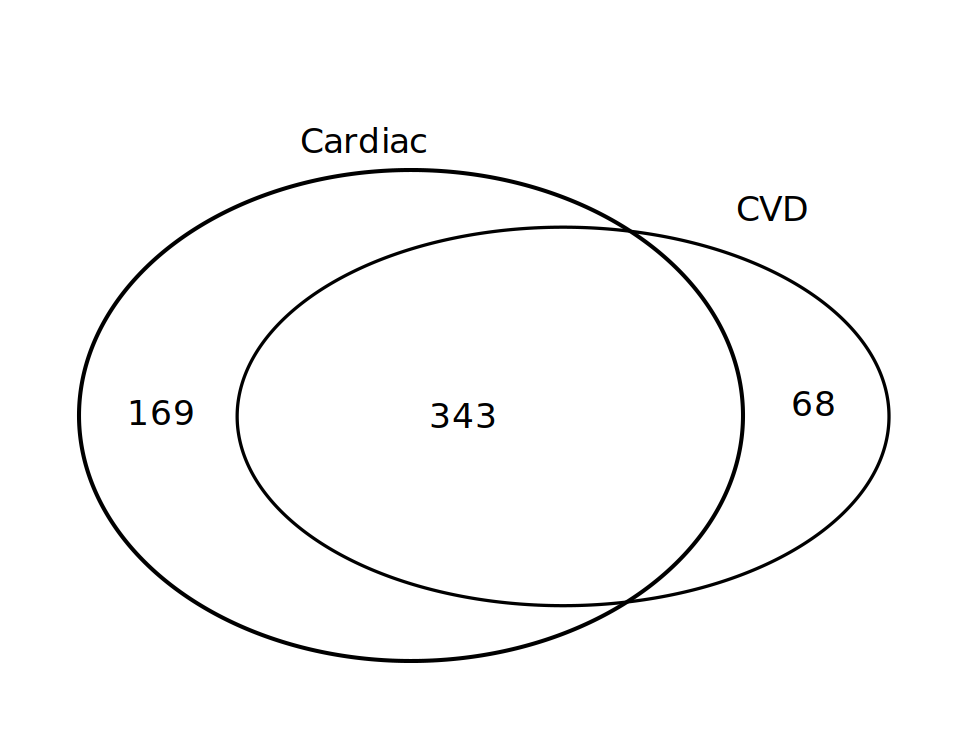

We choose as a target the union of the two pathologies

#### 1.2.3 Target

In [336]:
# target column will have:
#   1 if the patient died within 7 years of the first blood draw
#   0 otherwise
# since missing values in 'Date of death' column are considered as person that are still alive, they will have 0 in the target column
# 'target' = "is dead before 7 years by cardiac cause"
df['target']= (((df['Dataofdeath']-df['Dataprelievo'])/365 <= 7) & (df['Cardiaccauseofdeath'].dropna().astype(int) | df['CVDDeath'] ))
df['target'] = df['target'].astype(int)
df['target'].value_counts()

0    5240
1     580
Name: target, dtype: int64

In [337]:
df['target'].isnull().any()

False

In [341]:
# how many male and female are in the dataset
df['GenderMale'].value_counts()

1    4050
0    1770
Name: GenderMale, dtype: int64

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

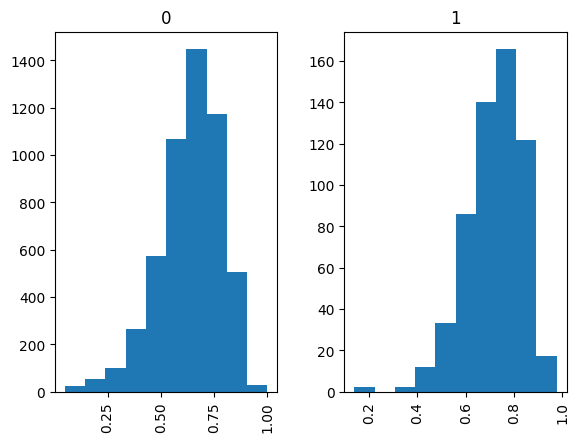

In [339]:
# histogram of the age of the patients in the dataset differentiating who has a cardiac cause of death and who has not
df['Age'].hist(by=df['target'])

In [ ]:
# altri plot?

#### 1.2.4 Matching CABG , Cabg

In [87]:
df['CABG '].dropna()

12       11/1/2011
32      29/11/2005
36       24/9/2013
60       23/2/2009
68       1/12/2007
           ...    
5789     12/4/2008
5794     1/12/2009
5795      4/2/2004
5799      8/5/2007
5802     30/3/2009
Name: CABG , Length: 635, dtype: object

In [346]:
pd.set_option('display.max_rows', 1000)
print(len(df[df['Cabg']==1]))
df[df['Cabg']==1][['Cabg','CABG']].isna().value_counts()
#with this command we see that we do not have missing dates for the CABG test

635


Cabg   CABG 
False  False    635
dtype: int64

#### 1.2.5 Matching PCI , Pci

In [347]:
print(len(df[df['Pci']==1]))
df[df['Pci']==1][['Pci','PCI']]['PCI'].isna().value_counts()
#with this command we see that we do not have missing dates for the CABG test

1013


False    1013
Name: PCI, dtype: int64

#### 1.2.5 Matching AMI , AMI followup

In [350]:
df.keys()

Index(['Age', 'BMI', 'CABG', 'Causeofdeath', 'Dataofdeath', 'Dataprelievo',
       'Diastolicbloodpressure', 'DimSettoIV', 'FollowUpData', 'Glycemia',
       'HDL', 'HR', 'Height', 'Ictus', 'LDL', 'NonFatalAMIFollowUp', 'PCI',
       'PatologiaTIROIDE', 'Systolicbloodpressure', 'TSH', 'Totalcholesterol',
       'Triglycerides', 'Weight', 'WmsiBas', 'fT3', 'fT4', 'fe', 'vsx',
       'GenderMale', 'Angina', 'PreviousCABG', 'PreviousPCI',
       'Previous_MyocardialInfarction', 'Acute_MyocardialInfarction',
       'Angiography', 'Vessels', 'CAD', 'Smoke_Historyofsmoke',
       'Diabetes_Historyofdiabetes', 'Hypertension_Historyofhypertension',
       'Dyslipidemia_Hystoryofdyslipidemia', 'FamilyhistoryofCAD',
       'Obesity_Historyofobesity', 'Documentedresting_orexertionalischemia',
       'PostischemicDilated_Cardiomyopathy', 'PrimaryDilated_Cardiomyopathy',
       'AtrialFibrillation', 'Paroxysmalatrialfibrillation', 'BBlockers',
       'Amiodarone', 'Calciumchannelblockers', 'Diureti

In [351]:
print(len(df[df['NonfatalAMI']==1]))
df[df['NonfatalAMI']==1][['NonFatalAMIFollowUp','NonfatalAMI']]['NonFatalAMIFollowUp'].isna().value_counts()

204


False    204
Name: NonFatalAMIFollowUp, dtype: int64

# Encoder building

In [ ]:
# todo

# Simple Classifier

In [ ]:
# todo

## Comparison